# Tech Challenge - Fase 1 - Grupo 19

## Modelo preditivo de custos em seguro saúde

*O objetivo deste notebook é ilustrar o processo de treinamento de um modelo de regressão linear capaz de prever o valor de encargos médicos a partir de dados pessoais*

### Sumário
1. Estudo da base de dados
2. Pré-processamento dos dados
3. Estratificação das bases de treino e teste
4. Execução e avaliação de vários modelos
5. Insights e melhorias, re-execução do passo 4

### Conclusões e Resultados
- Inicialmente, os modelos testados não tiveram um bom resultado (MAPE na casa dos 30%)
- Analisando a base de dados, identificamos que o modelo performa melhor prevendo custos abaixo de 17 mil. Isso devido a baixa ocorrência de valores acima desse patamar (apenas 25%)
- Foram testadas 2 estratégias para contornar a situação:
    - Retirar da amostra os registros com encargo maior que 17 mil (equivalente ao 75th percentile da base)
    - Executar um "upsampling" na amostra para que o modelo aprenda a prever custos maiores que esse valor
- **Veredito: A segunda estratégia parece mais adequada por atingir uma boa taxa de acerto sem descartar parte da amostra**

---



### Agrupando os imports necessários

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

### 1. Estudo da base de dados

Observações a respeito da base:
- 1338 registros, sem entradas nulas
- as colunas "gênero", "fumante" e "região" tem dados não-numéricos
- a distribuição de valores de imc aparenta uma curva normal
- 75% da base apresenta o valor da coluna "encargos" abaixo de 17mil
- o valor máximo de "encargos" é 63770, bem distante da média que é 13270

In [54]:

dataset = pd.read_csv('archive/insurance.csv')

dataset.head()


,idade,gênero,imc,filhos,fumante,região,encargos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [55]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

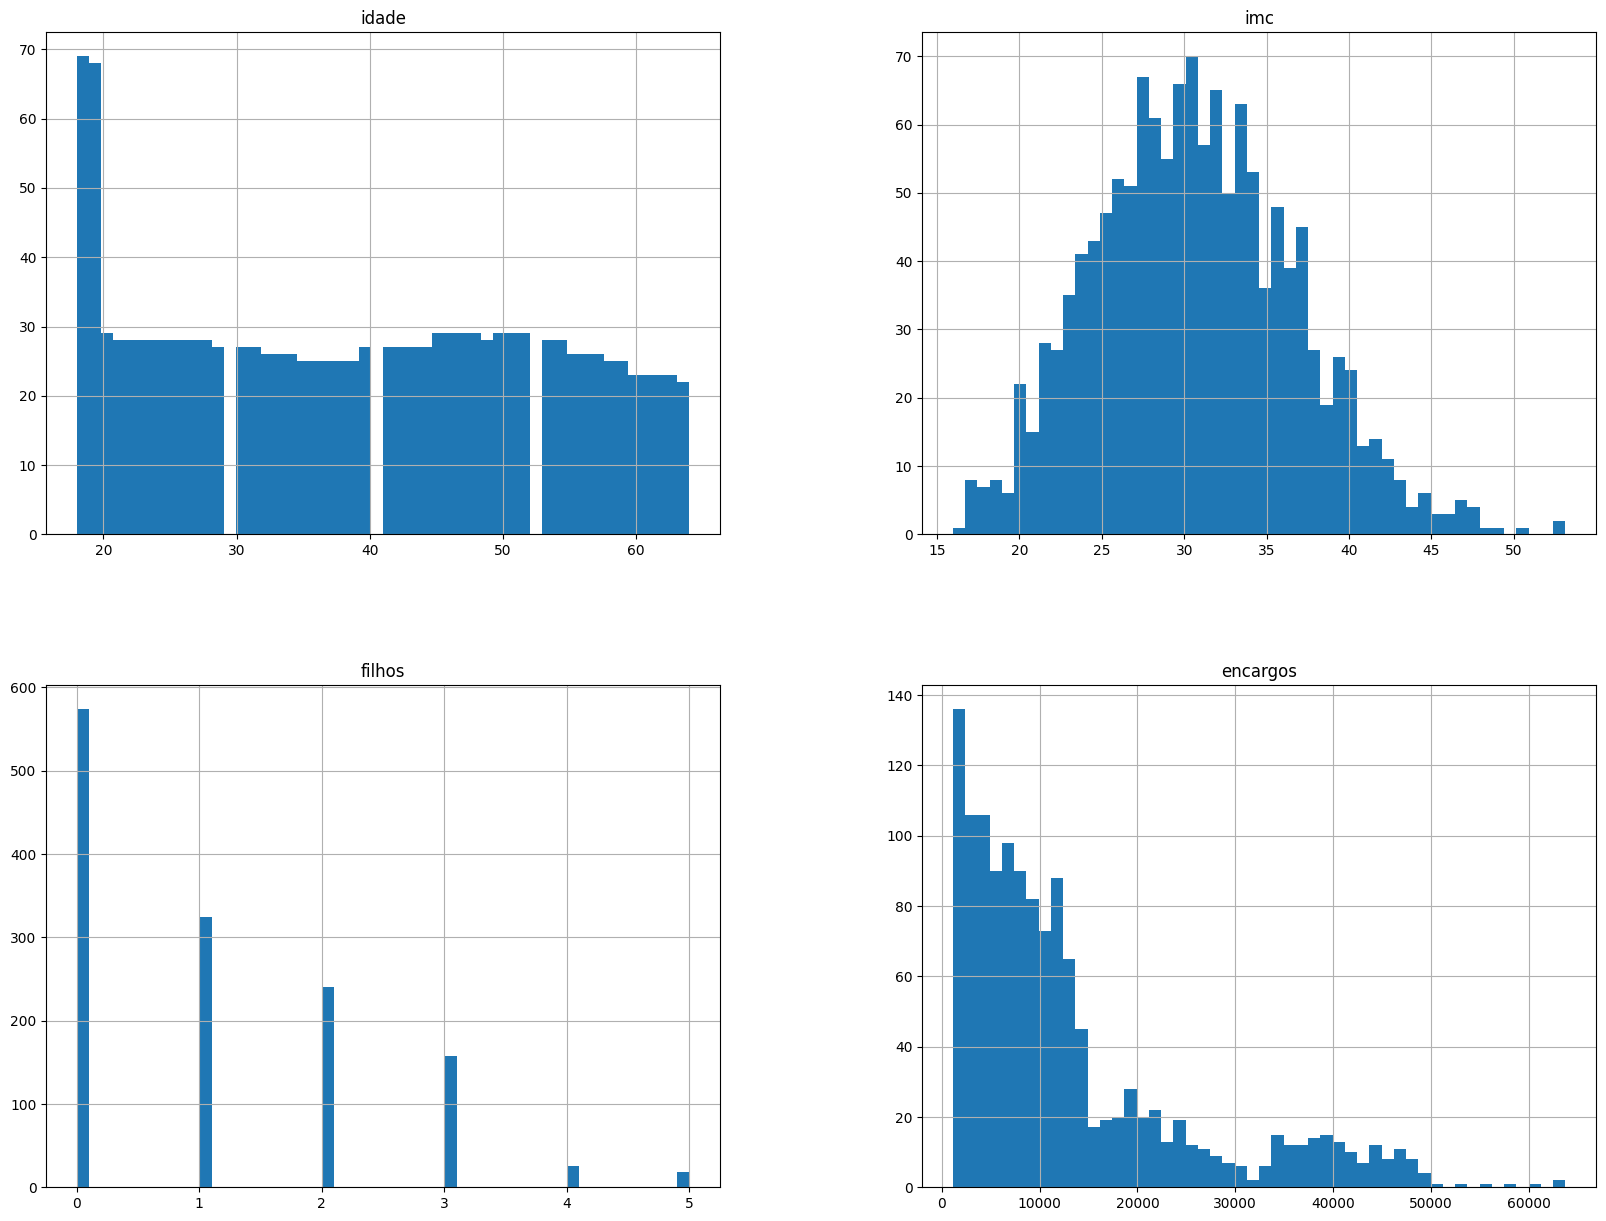

In [56]:
dataset.hist(bins=50, figsize=(20,15))

### 2. Pré-processamento dos dados

- Transformaremos as colunas não-numéricas ("gênero", "fumante" e "região") em numéricas
- Agruparemos os valores de "imc" em faixas

In [57]:
np.random.seed(42)

def preprocess_dataset(dataset): 

    dataset["faixas_imc"] = pd.cut(dataset["imc"],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

    label_encoder = LabelEncoder()

    dataset['genero_type'] = label_encoder.fit_transform(dataset['gênero'])
    dataset['fumante_type'] = label_encoder.fit_transform(dataset['fumante'])
    dataset['regiao_type'] = label_encoder.fit_transform(dataset['região'])

    dataset_tratado = dataset.drop(columns = [ "imc", "fumante", "região", "gênero"]).copy()

    return dataset_tratado


In [58]:
dataset_tratado = preprocess_dataset(dataset)
dataset_tratado.head()

,idade,filhos,encargos,faixas_imc,genero_type,fumante_type,regiao_type
0,19,0,16884.92400,3,0,1,3
1,18,1,1725.55230,4,1,0,2
2,28,3,4449.46200,4,1,0,2
3,33,0,21984.47061,2,1,0,1
4,32,0,3866.85520,3,1,0,1


### 3. Estratificação das bases de treino e teste

Analisando as correlações, apesar de "fumante_type" e "idade" apresentarem uma correlação maior com "encargos", optamos por estratificar as amostras de treino e teste utilizando a coluna "faixas_imc" pelo comportamento "normal" de distribuição na base.

In [59]:
corr_matrix = dataset_tratado.corr()
corr_matrix["encargos"].sort_values(ascending=False)

encargos        1.000000
fumante_type    0.787251
idade           0.299008
faixas_imc      0.205401
filhos          0.067998
genero_type     0.057292
regiao_type    -0.006208
Name: encargos, dtype: float64

In [60]:

def stratified_split(dataset):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(dataset, dataset["faixas_imc"]):
        strat_train_set = dataset.loc[train_index]
        strat_test_set = dataset.loc[test_index]

    print("Proporções na base de treino")
    print(strat_train_set["faixas_imc"].value_counts() / len(strat_train_set))
    print("Proporções na base de teste")
    print(strat_test_set["faixas_imc"].value_counts() / len(strat_test_set))

    # Removendo a coluna de faixas de imc
    strat_train_set = strat_train_set.drop(columns=['faixas_imc'], axis=1)
    strat_test_set = strat_test_set.drop(columns=['faixas_imc'], axis=1)

    X_train = strat_train_set.copy()
    y_train = X_train["encargos"].copy()     

    X_train = X_train.drop(columns=['encargos'], axis=1)

    X_test = strat_test_set.copy()
    y_test = X_test["encargos"].copy()

    X_test = X_test.drop(columns=['encargos'], axis=1)


    return X_train, y_train, X_test, y_test

In [61]:

X_train, y_train, X_test, y_test = stratified_split(dataset_tratado)


Proporções na base de treino
faixas_imc
4    0.296262
3    0.284112
5    0.169159
2    0.165421
6    0.069159
1    0.015888
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.283582
5    0.167910
2    0.164179
6    0.070896
1    0.014925
Name: count, dtype: float64


### 4. Execução e avaliação de vários modelos

- Testaremos vários modelos
    - LinearRegression
    - DecisionTreeRegressor
    - RandomForestRegressor
    - GradientBoostingRegressor
    - HuberRegressor
- Para cada um deles, plotamos um gráfico comparando os valores previstos (eixo Y) com os valores reais (eixo X). Quanto mais próximo da linha ideal, melhor

In [62]:
def evaluate_model(model, y_test, predictions, model_results):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, predictions)
    errors = np.abs(y_test - predictions)
    relative_errors = errors / np.abs(y_test)
    mape = np.mean(relative_errors) * 100
    
    model_results.append({
        'model': model.__class__.__name__,
        'mae': mae.round(2),
        'mse': mse.round(2),
        'rmse': rmse.round(2),
        'r2': r2.round(4),
        'mape': mape.round(2)
    })

    plt.scatter(y_test, predictions)
    plt.xlabel('Encargo Real')
    plt.ylabel('Encargo Previsto')
    
    plt.title('Real vs Previsto - ' + model.__class__.__name__)


    ideal_values = np.linspace(min(y_test), max(y_test)) 
    plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
    plt.legend()
    plt.show()


def run_model(model, X_train, y_train, X_test, y_test, model_results):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    evaluate_model(model, y_test, predictions, model_results)

def run_all_models(X_train, y_train, X_test, y_test):
    model_results = []

    models = [
        LinearRegression(),
        DecisionTreeRegressor(),
        GradientBoostingRegressor(),
        RandomForestRegressor(),
        HuberRegressor()
    ]

    for model in models:
        run_model(model, X_train, y_train, X_test, y_test, model_results)

    return model_results

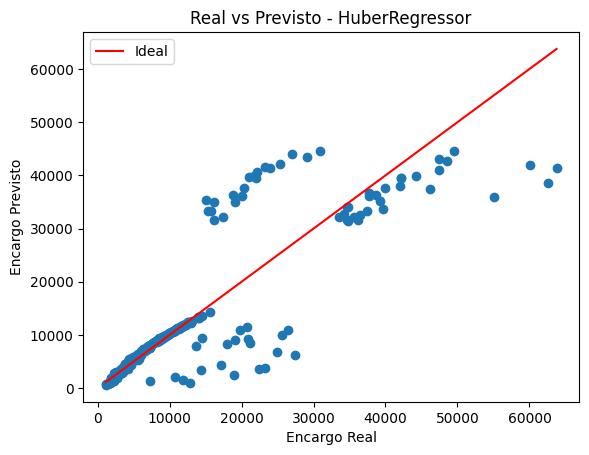

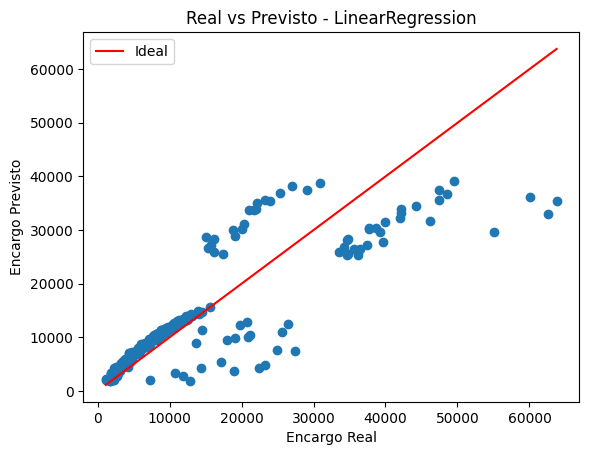

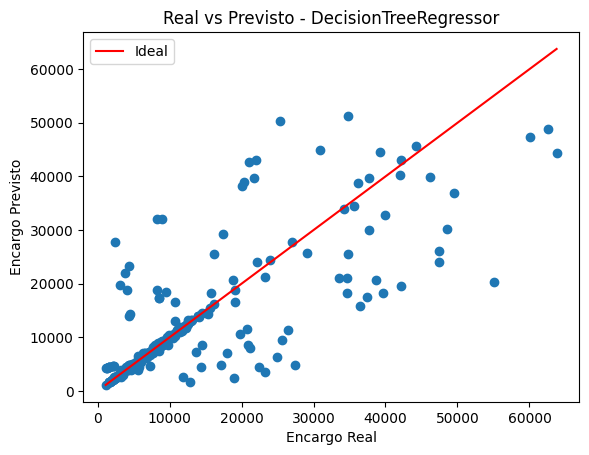

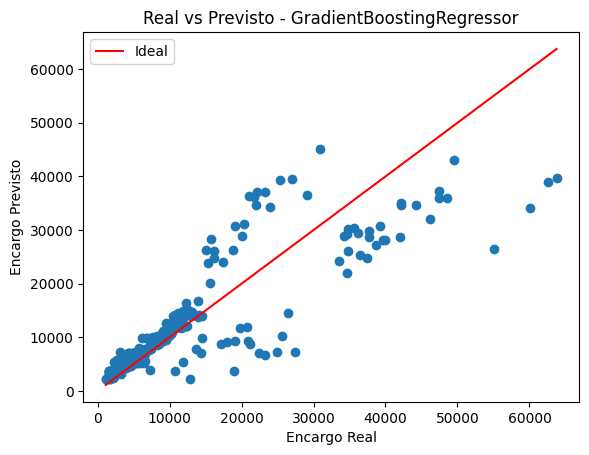

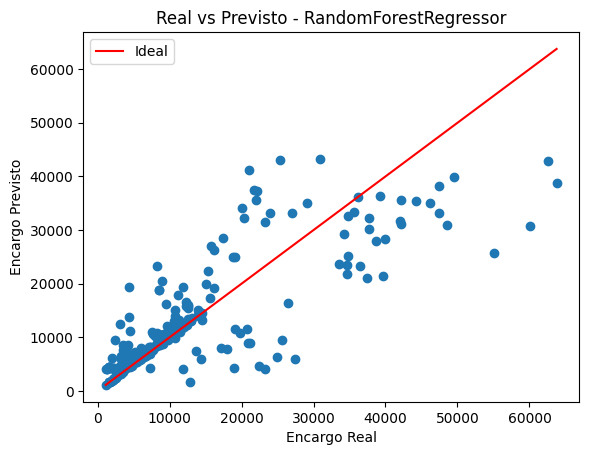

In [63]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

In [64]:
model_results_df = pd.DataFrame(model_results)

model_results_df.head()

,model,mae,mse,rmse,r2,mape
0,HuberRegressor,3244.60,43898153.23,6625.57,0.7090,21.32
1,LinearRegression,4100.91,42149780.10,6492.29,0.7206,31.83
2,DecisionTreeRegressor,3907.51,62678520.26,7916.98,0.5845,35.83
3,GradientBoostingRegressor,3998.64,41482944.64,6440.73,0.7250,34.84
4,RandomForestRegressor,4022.07,47976113.08,6926.48,0.6819,35.93


### 5. Insights e melhorias, re-execução do passo 4

Análise do valor máximo e médio dos encargos.

In [ ]:
print("Valor máximo dos encargos:", dataset_tratado['encargos'].max())

In [ ]:
print("Valor médio dos encargos:", dataset_tratado['encargos'].mean())

Análise da variação de amplitude da variável encargos.

In [ ]:
import matplotlib.pyplot as plt

# Criar o gráfico de boxplot
plt.boxplot(dataset_tratado['encargos'])
plt.title('Encargos')
plt.ylabel('Valores')
plt.show()

***Estratégia 1: Observaremos o comportamento dos modelos retirando-se os 25% da base cujo encargo é maior que o 75th percetile***

In [65]:
def recuperar_valor_quartil(data, quartil):
    """
    Calcula o valor do quartil especificado para os dados fornecidos.

    Parâmetros:
        data (array): Array contendo os dados.
        quartil (int): Número do quartil desejado (25, 50 ou 75).

    Retorna:
        float: Valor do quartil especificado.
    """
    return np.percentile(data, quartil)

Q3 = recuperar_valor_quartil(dataset_tratado['encargos'], 75)

dataset_ajustado = dataset_tratado[dataset_tratado['encargos'] <= Q3]

dataset_ajustado.reset_index(drop=True, inplace=True)

X_train, y_train, X_test, y_test = stratified_split(dataset_ajustado)

Proporções na base de treino
faixas_imc
4    0.298005
3    0.288030
2    0.172070
5    0.155860
6    0.067332
1    0.018703
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.298507
3    0.288557
2    0.169154
5    0.154229
6    0.069652
1    0.019900
Name: count, dtype: float64


**Testando novamente os modelos**

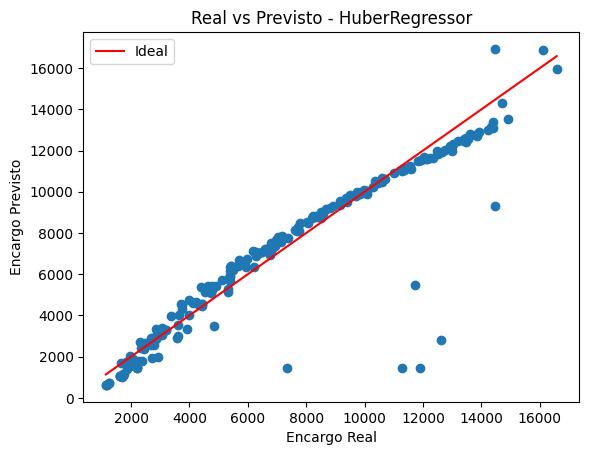

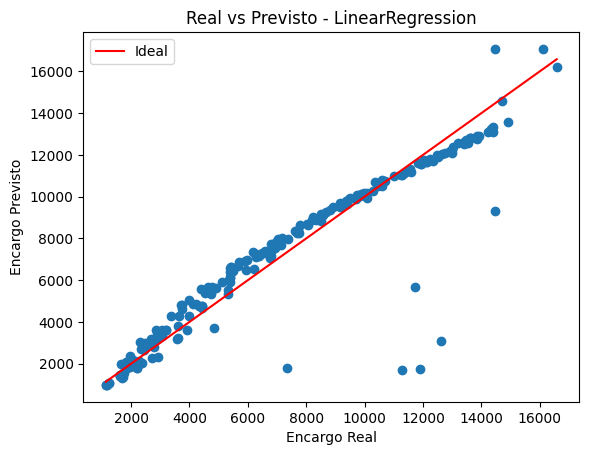

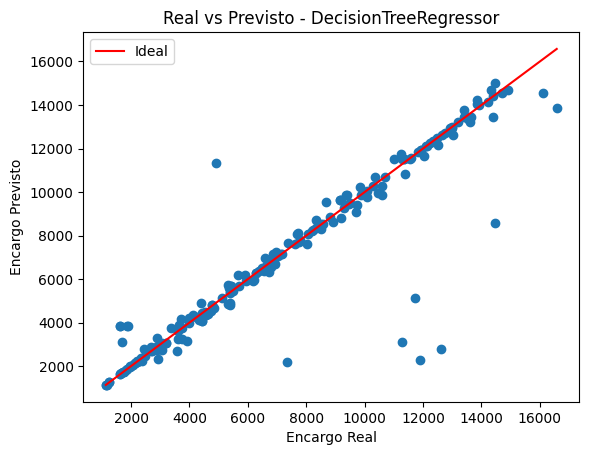

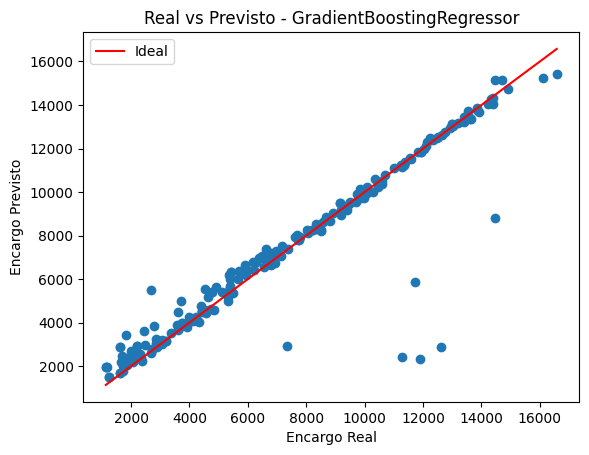

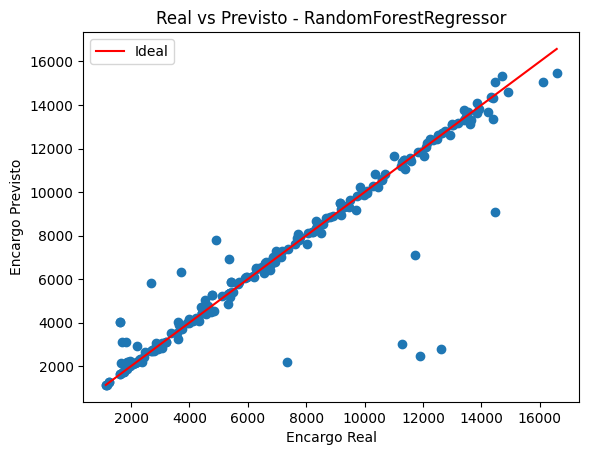

In [66]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

In [67]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape
0,HuberRegressor,729.32,2355039.12,1534.61,0.8621,12.33
1,LinearRegression,765.08,2301312.40,1517.01,0.8652,11.79
2,DecisionTreeRegressor,493.66,2214173.48,1488.01,0.8703,8.31
3,GradientBoostingRegressor,502.97,1944059.49,1394.30,0.8861,10.31
4,RandomForestRegressor,453.97,1915686.71,1384.08,0.8878,8.10


***Estratégia 2: Utilizaremos upsampling para aumentar a nossa amostra original e verificar o comportamento dos modelos***

In [68]:
upsample_dataset = dataset.sample(n=100000, replace=True, random_state=42, ignore_index=True)

upsample_dataset_tratado = preprocess_dataset(upsample_dataset)

upsample_dataset_tratado.describe()

,idade,filhos,encargos,genero_type,fumante_type,regiao_type
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,39.228700,1.090940,13291.301241,0.50348,0.207060,1.523950
std,14.019965,1.199952,12122.225553,0.49999,0.405201,1.104219
min,18.000000,0.000000,1121.873900,0.00000,0.000000,0.000000
25%,27.000000,0.000000,4738.268200,0.00000,0.000000,1.000000
50%,39.000000,1.000000,9361.326800,1.00000,0.000000,2.000000
75%,51.000000,2.000000,16796.411940,1.00000,0.000000,2.000000
max,64.000000,5.000000,63770.428010,1.00000,1.000000,3.000000


In [69]:
X_train, y_train, X_test, y_test = stratified_split(upsample_dataset_tratado)

Proporções na base de treino
faixas_imc
4    0.297438
3    0.283187
5    0.167763
2    0.165075
6    0.070638
1    0.015900
Name: count, dtype: float64
Proporções na base de teste
faixas_imc
4    0.29745
3    0.28320
5    0.16775
2    0.16505
6    0.07065
1    0.01590
Name: count, dtype: float64


**Testando novamente os modelos**

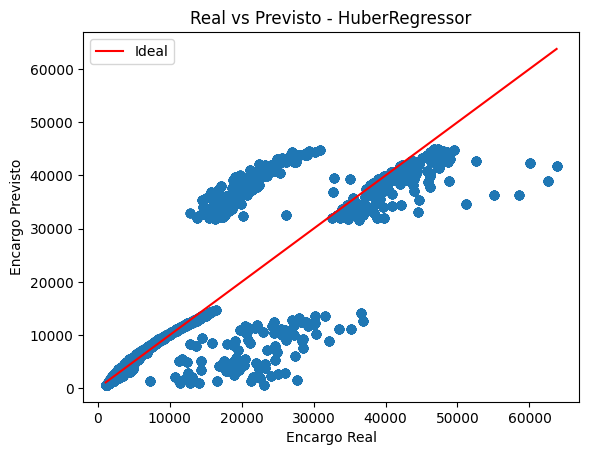

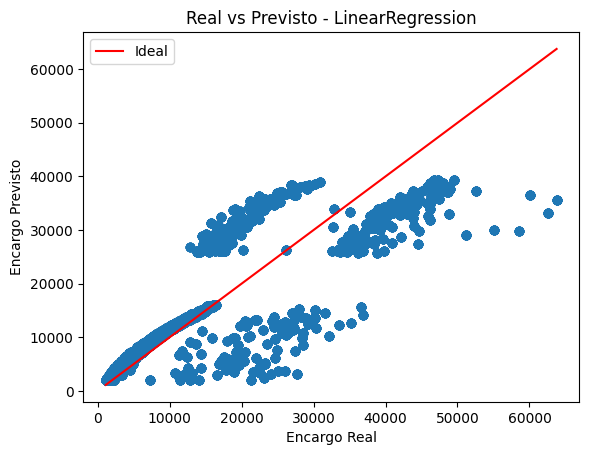

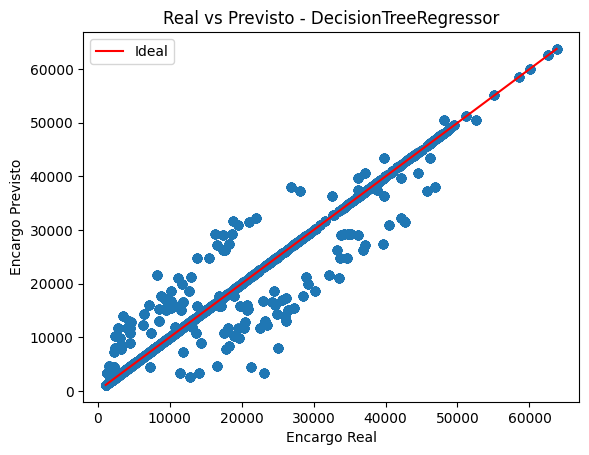

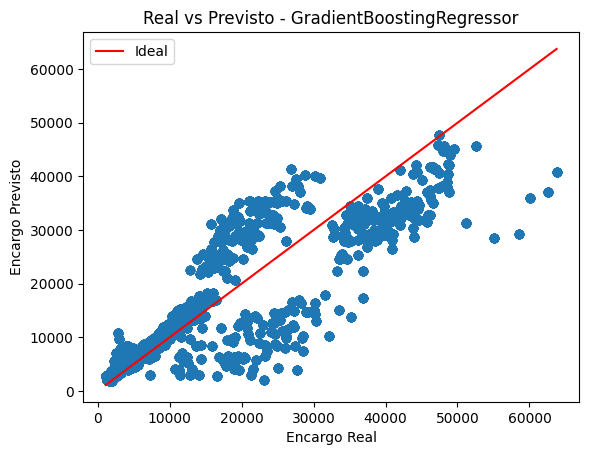

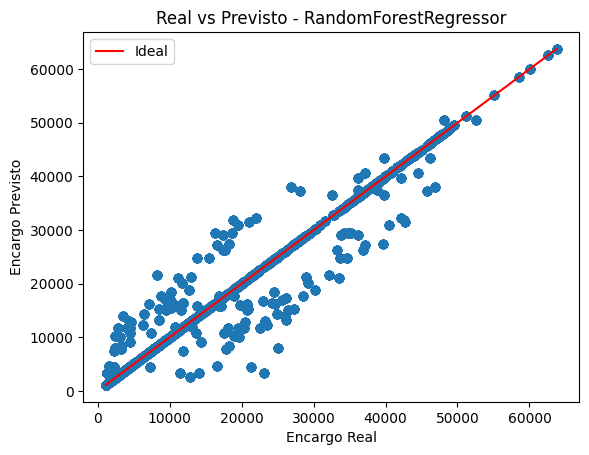

In [70]:
model_results = run_all_models(X_train, y_train, X_test, y_test)

In [71]:
model_results_df = pd.DataFrame(model_results)
model_results_df.head()

,model,mae,mse,rmse,r2,mape
0,HuberRegressor,3474.44,49544592.68,7038.79,0.6653,21.49
1,LinearRegression,4101.72,40576567.76,6369.97,0.7259,31.60
2,DecisionTreeRegressor,846.86,7098651.65,2664.33,0.9521,10.20
3,GradientBoostingRegressor,3670.50,33382205.20,5777.73,0.7745,31.04
4,RandomForestRegressor,846.33,7097726.39,2664.16,0.9521,10.19
